In [186]:
'''
Question 2.2 Skeleton Code

Here you should implement and evaluate the Conditional Gaussian classifier.
'''

import data
import numpy as np
# Import pyplot - plt.imshow is useful!
import matplotlib.pyplot as plt

def compute_mean_mles(train_data, train_labels):
    '''
    Compute the mean estimate for each digit class

    Should return a numpy array of size (10,64)
    The ith row will correspond to the mean estimate for digit class i
    '''
    means = None
    # Compute means
    for i in sorted(set(train_labels)):
        ind = np.squeeze(np.where(train_labels == i))
        mean = np.mean(train_data[ind], axis=0)
        if means is None:
            means = mean
        else:
            means = np.vstack([means, mean])   
    return means

def compute_sigma_mles(train_data, train_labels):
    '''
    Compute the covariance estimate for each digit class

    Should return a three dimensional numpy array of shape (10, 64, 64)
    consisting of a covariance matrix for each digit class 
    To ensure numerical stability,
    you may have to add a small positive value to the diagonal of each covariance matrix. 
    For this assignment you can add 0.01I to each matrix.
    '''
    
    means = compute_mean_mles(train_data, train_labels)
    d = train_data.shape[1]
    X = {}
    for k in sorted(set(train_labels)):
        ind = np.squeeze(np.where(train_labels == k))
        X[k] = train_data[ind]
    covariances = []
    # Compute covariances
    for k in sorted(set(train_labels)):
        k = int(k)
        covariance = np.dot((X[k] - means[k]).T, (X[k] - means[k])) / X[k].shape[0]
        covariances.append(covariance + 0.01 * np.identity(d))     
    return np.stack(covariances)

def plot_cov_diagonal(covariances):
    cov_diags = []
    # Plot the diagonal of each covariance matrix side by side
    for i in range(10):
        cov_diag = np.log(np.diag(covariances[i])).reshape(8, 8)
        cov_diags.append(cov_diag)
    cov_diags = np.concatenate(cov_diags, axis = 1)
    plt.imshow(cov_diags, cmap='gray')
    plt.show()
      
def generative_likelihood(digits, means, covariances):
    '''
    Compute the generative log-likelihood:
        log p(x|y,mu,Sigma)

    Should return an n x 10 numpy array 
    '''
    import math
    n = digits.shape[0]
    d = digits.shape[1]
    K = means.shape[0]
    likelihoods = []
    for i in range(n):
        likelihood = []
        x = digits[i].reshape(d, 1)
        for k in range(K):           
            mu = means[k].reshape(d, 1)
            sigma = covariances[k].reshape(d, d)
            p = (2 * math.pi)**(-d / 2) * \
                 np.linalg.det(sigma)**(-1 / 2) * \
                 np.exp((-1 / 2) * np.dot(np.dot((x - mu).T, np.linalg.inv(sigma)), (x - mu)))
            p = np.log(np.squeeze(p))
            likelihood.append(p)
        likelihoods.append(likelihood)
    return np.array(likelihoods)

def conditional_likelihood(digits, means, covariances):
    '''
    Compute the conditional likelihood:

        log p(y|x, mu, Sigma)

    This should be a numpy array of shape (n, 10)
    Where n is the number of datapoints and 10 corresponds to each digit class
    '''
    prior = np.array([0.1 for i in range(means.shape[0])]).reshape(1, means.shape[0])
    likelihood = np.exp(generative_likelihood(digits, means, covariances))
    likelihood = likelihood * prior
    return np.log(likelihood / np.sum(likelihood, axis=1, keepdims=True))

def avg_conditional_likelihood(digits, labels, means, covariances):
    '''
    Compute the average conditional likelihood over the true class labels

        AVG( log p(y_i|x_i, mu, Sigma) )

    i.e. the average log likelihood that the model assigns to the correct class label
    '''
    cond_likelihood = conditional_likelihood(digits, means, covariances)
    true_likelihood = 0
    N = digits.shape[0]
    for i in range(N):
        k = int(labels[i])
        true_likelihood += cond_likelihood[i][k]
    return true_likelihood / N

def classify_data(digits, means, covariances):
    '''
    Classify new points by taking the most likely posterior class
    '''
    cond_likelihood = conditional_likelihood(digits, means, covariances)
    # Compute and return the most likely class
    return np.argmax(cond_likelihood, axis=1)

def plot_eigen_vector(covariances):
    K = covariances.shape[0]
    eigs = []
    for k in range(K):
        w, v = np.linalg.eig(covariances[k])
        eig = v[:, np.argmax(w)]
        eigs.append(eig.reshape(8, 8))
    eigs = np.concatenate(eigs, axis = 1)
    plt.imshow(eigs, cmap='gray')
    plt.show()

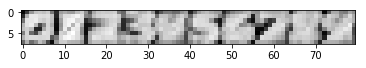

average conditional log-likelihood for
train set: -0.12462443666862971
test set: -0.19667320325525603
accuracy on trainset: 0.9814285714285714
accuracy on testset: 0.97275


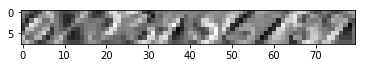

In [187]:
def main():
    from sklearn.metrics import accuracy_score
    train_data, train_labels, test_data, test_labels = data.load_all_data('data')

    # Fit the model
    means = compute_mean_mles(train_data, train_labels)
    covariances = compute_sigma_mles(train_data, train_labels)
    # Evaluation
    plot_cov_diagonal(covariances)
    avg_train_likelihood = avg_conditional_likelihood(train_data, train_labels, means, covariances)
    avg_test_likelihood = avg_conditional_likelihood(test_data, test_labels, means, covariances)
    print("average conditional log-likelihood for\ntrain set: {}\ntest set: {}".
          format(avg_train_likelihood, avg_test_likelihood))
    # Prediction
    train_pred = classify_data(train_data, means, covariances)
    train_acc = accuracy_score(train_labels, train_pred)
    print("accuracy on trainset: {}".format(train_acc))
    test_pred = classify_data(test_data, means, covariances)
    test_acc = accuracy_score(test_labels, test_pred)
    print("accuracy on testset: {}".format(test_acc))
    # Extra work
    plot_eigen_vector(covariances)
if __name__ == '__main__':
    main()